<a href="https://colab.research.google.com/github/obeabi/ProjectPortfolio/blob/master/FlightCancellation_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Written by Abiola Obembe
# SDS Challenge #1 - Flight Cancellations
## 2020-10-30



## Problem Statement
I have been hired by the US Department of Transportation (DOT) to analyze data from multiple airline carriers in the United States. The DOT wants to help airline carriers reduce the number of flight cancellations and improve travelers' experiences. My job is to help the DOT predict whether or not a flight will be canceled based on the data provided.

### Step 1: Data Preprocessing Tools

In [1]:

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
!pip install imbalanced-learn
!pip install category_encoders
import category_encoders as ce

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print('Libraries installed successfully!')

Libraries installed successfully!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Importing the dataset and check the shape and total number of missing values

df_train = pd.read_csv('public_flights.csv')

df_train.head()



,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,CANCELLED
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,205.0,1448,430,0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,280.0,2330,750,0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,286.0,2296,806,0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,285.0,2342,805,0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,235.0,1448,320,0


In [3]:
# print target column name as a list
target_column = [df_train.columns[-1]]

print(target_column)

['CANCELLED']


In [4]:
# Examine target column for unbalanced data
df_train[target_column].value_counts()

CANCELLED
0            810176
1             28682
dtype: int64

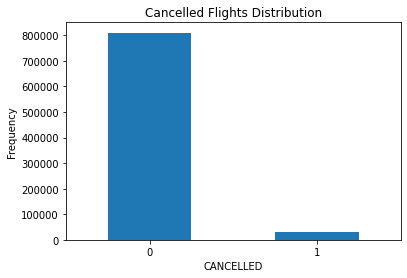

In [5]:
count_classes = pd.value_counts(df_train['CANCELLED'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title("Cancelled Flights Distribution")
plt.xticks(range(2))
plt.xlabel("CANCELLED")
plt.ylabel('Frequency')
plt.show()

In [6]:
# gET THE CANCELLED AND NOT CANCEELED FLIFGTS
Cancelled = df_train[df_train['CANCELLED']== 1]
notCancelled = df_train[df_train['CANCELLED']== 0]

print(Cancelled.shape, notCancelled.shape)

(28682, 14) (810176, 14)


In [7]:
# Importing the train-set nd check the shape and total number of missing values

print("The shape of the train-set is:", (df_train.shape))
print("The number of rows in the train-set is:", str(df_train.shape[0]))
print("The number of columns in the train-set is:", str(df_train.shape[1]))

missing_valuestrain = df_train.isnull().sum().sum()

print("The number of missing values in the train-set is:", str(missing_valuestrain))

The shape of the train-set is: (838858, 14)
The number of rows in the train-set is: 838858
The number of columns in the train-set is: 14
The number of missing values in the train-set is: 5983


In [8]:
# create dataframe for test test
df_test = pd.read_csv('pred_flights.csv')
df_test.head()

,2015,2,25,3,WN,1046,N731SA,LAS,PHX,700,65,255,905
0,2015,2,25,3,WN,2251,N279WN,LAS,RNO,700,80,345,820
1,2015,2,25,3,WN,857,N277WN,LAS,SMF,700,90,397,830
2,2015,2,25,3,WN,2864,N8632A,LAX,BWI,700,295,2329,1455
3,2015,2,25,3,WN,3220,N8659D,LAX,PHX,700,80,370,920
4,2015,2,25,3,WN,2954,N789SW,LGA,HOU,700,265,1428,1025


In [9]:
# test set dataframe is missing headers information so we will re-initailize it, deleting the target column label
labels = df_train.columns

new_label= labels[:-1]  # select all column labels except the target column

#new_label
df_test = pd.read_csv('pred_flights.csv', header =None, names = new_label)

df_test.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL
0,2015,2,25,3,WN,1046,N731SA,LAS,PHX,700,65,255,905
1,2015,2,25,3,WN,2251,N279WN,LAS,RNO,700,80,345,820
2,2015,2,25,3,WN,857,N277WN,LAS,SMF,700,90,397,830
3,2015,2,25,3,WN,2864,N8632A,LAX,BWI,700,295,2329,1455
4,2015,2,25,3,WN,3220,N8659D,LAX,PHX,700,80,370,920


In [10]:
# Importing the test-set and check the shape and total number of missing values

print("The shape of the test-set is:", (df_test.shape))
print("The number of rows in the test-set is:", str(df_test.shape[0]))
print("The number of columns in the test-set is:", str(df_test.shape[1]))

missing_valuestest = df_test.isnull().sum().sum()

print("The number of missing values in the test-set is:", str(missing_valuestest))

The shape of the test-set is: (209717, 13)
The number of rows in the test-set is: 209717
The number of columns in the test-set is: 13
The number of missing values in the test-set is: 1769


### Step 2: Feature Engineering (Training and Test Set )

In [11]:
# Examine the data types for train dataframe
df_train.dtypes

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
SCHEDULED_TIME         float64
DISTANCE                 int64
SCHEDULED_ARRIVAL        int64
CANCELLED                int64
dtype: object

In [12]:
# Check for training set data frame info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838858 entries, 0 to 838857
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 838858 non-null  int64  
 1   MONTH                838858 non-null  int64  
 2   DAY                  838858 non-null  int64  
 3   DAY_OF_WEEK          838858 non-null  int64  
 4   AIRLINE              838858 non-null  object 
 5   FLIGHT_NUMBER        838858 non-null  int64  
 6   TAIL_NUMBER          832877 non-null  object 
 7   ORIGIN_AIRPORT       838858 non-null  object 
 8   DESTINATION_AIRPORT  838858 non-null  object 
 9   SCHEDULED_DEPARTURE  838858 non-null  int64  
 10  SCHEDULED_TIME       838856 non-null  float64
 11  DISTANCE             838858 non-null  int64  
 12  SCHEDULED_ARRIVAL    838858 non-null  int64  
 13  CANCELLED            838858 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 89.6+ MB


In [13]:
# Dealing with missing values in the train-set

df_train.isnull().sum()

YEAR                      0
MONTH                     0
DAY                       0
DAY_OF_WEEK               0
AIRLINE                   0
FLIGHT_NUMBER             0
TAIL_NUMBER            5981
ORIGIN_AIRPORT            0
DESTINATION_AIRPORT       0
SCHEDULED_DEPARTURE       0
SCHEDULED_TIME            2
DISTANCE                  0
SCHEDULED_ARRIVAL         0
CANCELLED                 0
dtype: int64

#### (A) Dealing with Missing Values

In [14]:
# Remove rows with missing target, separate target from predictors
X_full = df_train.copy()
X_full.dropna(axis=0, subset=['CANCELLED'], inplace=True)
y = X_full.CANCELLED
X_full.drop(['CANCELLED'], axis=1, inplace=True)

# Show X_full dataframe representing predictors only
X_full.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,205.0,1448,430
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,280.0,2330,750
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,286.0,2296,806
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,285.0,2342,805
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,235.0,1448,320


In [15]:
# Print first 10 entries of target column
y[0:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: CANCELLED, dtype: int64

In [16]:
# Break off validation set from training data
from sklearn.model_selection import train_test_split
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y,train_size=0.8, test_size=0.2, random_state=0)

# Organize test set
X_test_full = df_test.copy()

In [17]:
# Select categorical columns from X_train_full
# All categorical columns
category_cols = [col for col in X_train_full.columns if X_train_full[col].dtype == "object"]
category_cols

['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']

In [18]:
# Print object caregories for X_train_full for inspection
X_train_full[category_cols].head()

,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT
645400,HA,N370HA,HNL,PDX
546962,DL,N334NW,SAN,MSP
159193,EV,N14904,IAH,ATL
288445,DL,N553NW,MCO,ATL
298874,WN,N8312C,ALB,MCO


In [19]:
# Let us see the cardanilatity of each column for the categorical columns in X_train_full and X_valid_full
# Unique value sin each columns
for cols in category_cols:
    print("Unique values in", cols,  "column in training data:", X_train_full[cols].nunique())
    print("\nUnique values in" , cols,  "column in validation data:", X_valid_full[cols].nunique())

Unique values in AIRLINE column in training data: 14

Unique values in AIRLINE column in validation data: 14
Unique values in TAIL_NUMBER column in training data: 4470

Unique values in TAIL_NUMBER column in validation data: 4372
Unique values in ORIGIN_AIRPORT column in training data: 315

Unique values in ORIGIN_AIRPORT column in validation data: 315
Unique values in DESTINATION_AIRPORT column in training data: 315

Unique values in DESTINATION_AIRPORT column in validation data: 315


##### We observe that the cardinality of the columns are all greater than 10 hence one-hot encoding will lead to a huge number of new columns and hence result in the curse of dimensionality problem. Hence in this project we proceed with label encoding for the baseline project. We hope to improve the categorical encoding columns with the category encoder library in the future using the count encoder, target encoder and catboost encoder.

In [20]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and
                    X_train_full[cname].dtype == "object"]
low_cardinality

[]

In [21]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
high_cardinality = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() > 10 and
                    X_train_full[cname].dtype == "object"]
high_cardinality

['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']

##### We observe that all columns have high cardinality

In [22]:
# Columns that can be safely label encoded
good_label_cols = [col for col in category_cols if
                   set(X_train_full[col]) == set(X_valid_full[col])]


# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(category_cols) - set(good_label_cols))

print('Categorical columns that will be label encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)


Categorical columns that will be label encoded: ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']

Categorical columns that will be dropped from the dataset: ['TAIL_NUMBER']


In [23]:
# Drop categorical columns that will not be encoded
label_X_train = X_train_full.drop(bad_label_cols, axis=1)
label_X_valid = X_valid_full.drop(bad_label_cols, axis=1)
label_X_test = X_test_full.drop(bad_label_cols, axis=1)

# print dataframe for inspection
label_X_train.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL
645400,2015,2,12,4,HA,26,HNL,PDX,1500,330.0,2603,2230
546962,2015,2,6,5,DL,1864,SAN,MSP,625,227.0,1532,1212
159193,2015,1,11,7,EV,4427,IAH,ATL,1125,119.0,689,1424
288445,2015,1,19,1,DL,1112,MCO,ATL,2030,87.0,404,2157
298874,2015,1,20,2,WN,4858,ALB,MCO,1505,195.0,1073,1820


In [24]:
# Apply label encoder to each column with categorical data
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for col in good_label_cols:
    label_X_train[col] = label_encoder.fit_transform(X_train_full[col])
    label_X_valid[col] = label_encoder.transform(X_valid_full[col])
    label_X_test[col] = label_encoder.transform(X_test_full[col])

label_X_train.head(10)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL
645400,2015,2,12,4,6,26,137,230,1500,330.0,2603,2230
546962,2015,2,6,5,3,1864,262,211,625,227.0,1532,1212
159193,2015,1,11,7,4,4427,146,18,1125,119.0,689,1424
288445,2015,1,19,1,3,1112,188,18,2030,87.0,404,2157
298874,2015,1,20,2,13,4858,12,188,1505,195.0,1073,1820
460756,2015,1,31,6,13,615,188,79,855,180.0,973,1055
783876,2015,2,21,6,13,2663,169,97,1330,95.0,583,1605
72002,2015,1,5,1,8,312,188,7,1438,127.0,852,1645
709158,2015,2,16,1,13,271,111,49,1855,150.0,925,2125
120068,2015,1,8,4,9,4592,280,130,1530,99.0,463,1709


In [25]:
# Select numerical columns
numerical_cols = [cname for cname in label_X_train.columns if
                label_X_train[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
categorical_cols = good_label_cols
my_cols = categorical_cols + numerical_cols  # sometime use category_cols instead of good_label_cols for one-hot encoding
X_train = label_X_train[my_cols].copy()
X_valid = label_X_valid[my_cols].copy()
X_test = label_X_test[my_cols].copy()


In [26]:
# Define Preprocessing Steps and import dependecies
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')
#numerical_transformer = KNNImputer(n_neighbors=3)
#numerical_transformer = Pipeline(steps=[('imputer',SimpleImputer() ),('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent'))])
#categorical_transformer = Pipeline(steps=[ ('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder())])



### Model using Decision Tree Classifier

In [27]:
# Step 1 : Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(transformers=[ ('num', numerical_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols) ])

# Step 2: Define the Model
from sklearn.tree import DecisionTreeClassifier
model_1 = DecisionTreeClassifier(random_state=0)

# Step 3: Create and Evaluate the Pipeline
from sklearn.metrics import accuracy_score,average_precision_score,f1_score

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model_1)])

# Preprocessing of training data, fit model
# implement under_sampling to account for unbalanced data
#from imblearn.under_sampling import NearMiss

#rm = NearMiss(random_state = 1)
#label_X_train_res, y_train_res = rm.fit_sample(label_X_train,y_train)
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = accuracy_score(y_valid, preds)
avg_precisionScore = average_precision_score(y_valid, preds)

print('Accuracy Score:', score)
print('Average Precision Score:', avg_precisionScore)
print("The macro averaged f1_score is :", f1_score(y_valid, preds, average='macro'))
print("The mairo averaged f1_score is :", f1_score(y_valid, preds, average='micro'))
print("The weighted averaged f1_score is :", f1_score(y_valid, preds, average='weighted'))
print("The  f1_score is :", f1_score(y_valid, preds, average='macro'))

Accuracy Score: 0.9591111746894595
Average Precision Score: 0.19727892054971788
The macro averaged f1_score is : 0.7002445217648174
The mairo averaged f1_score is : 0.9591111746894594
The weighted averaged f1_score is : 0.9597686770597895
The  f1_score is : 0.7002445217648174


In [28]:
# Cross validation Score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(my_pipeline, X_train, y_train, cv=3)

# Print the mean score and 95% confidence interval
print("Accuracy: %0.2f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.96 (+/- 0.00069)


In [29]:
# print classification report (confusion matrix)
from sklearn.metrics import classification_report
print (classification_report(y_valid, preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    162039
           1       0.41      0.44      0.42      5733

    accuracy                           0.96    167772
   macro avg       0.69      0.71      0.70    167772
weighted avg       0.96      0.96      0.96    167772



In [30]:
# Use imbalance library to calculate sensitiivty score  of model
from imblearn.metrics import sensitivity_score
print(sensitivity_score(y_valid, preds, average='macro'))
print(sensitivity_score(y_valid, preds, average='micro'))
print(sensitivity_score(y_valid, preds, average='weighted'))
print(sensitivity_score(y_valid, preds, average=None))


0.7069283108834434
0.9591111746894595
0.9591111746894595
[0.97761033 0.43624629]


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [31]:
# Use imbalance library to calculate specificity score  of model
from imblearn.metrics import specificity_score
print(specificity_score(y_valid, preds, average='macro'))
print(specificity_score(y_valid, preds, average='micro'))
print(specificity_score(y_valid, preds, average='weighted'))
print(specificity_score(y_valid, preds, average=None))

0.7069283108834434
0.9591111746894595
0.45474544707742726
[0.43624629 0.97761033]


In [32]:
# Preprocessing of test data, fit model
preds_test = my_pipeline.predict(X_test)

# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,'CANCELLED': preds_test})
output.to_csv('submission_DT.csv', index=False)

### Model using Random Forest Classifier

In [33]:
# Step 1 : Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(transformers=[ ('num', numerical_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols) ])

# Step 2: Define the Model
from sklearn.ensemble import RandomForestClassifier
model_2 = RandomForestClassifier(n_estimators=100, random_state=0)

# Step 3: Create and Evaluate the Pipeline
from sklearn.metrics import accuracy_score,average_precision_score

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model_2)])

# Preprocessing of training data, fit model
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = accuracy_score(y_valid, preds)
avg_precisionScore = average_precision_score(y_valid, preds)

print('Accuracy Score:', score)
print('Average Precision Score:', avg_precisionScore)
print("The macro averaged f1_score is :", f1_score(y_valid, preds, average='macro'))
print("The mairo averaged f1_score is :", f1_score(y_valid, preds, average='micro'))
print("The weighted averaged f1_score is :", f1_score(y_valid, preds, average='weighted'))
print("The  f1_score is :", f1_score(y_valid, preds, average='macro'))

Accuracy Score: 0.974507069117612
Average Precision Score: 0.2884753409283083
The macro averaged f1_score is : 0.7243092067013861
The mairo averaged f1_score is : 0.974507069117612
The weighted averaged f1_score is : 0.9689951926914291
The  f1_score is : 0.7243092067013861


In [34]:
# Cross validation Score
##scores = cross_val_score(my_pipeline, X_train, y_train, cv=5)

# Print the mean score and 95% confidence interval

#print("Accuracy: %0.2f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

In [35]:
# print classification report (confusion matrix)
from sklearn.metrics import classification_report
print (classification_report(y_valid, preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    162039
           1       0.83      0.32      0.46      5733

    accuracy                           0.97    167772
   macro avg       0.90      0.66      0.72    167772
weighted avg       0.97      0.97      0.97    167772



In [36]:
# Use imbalance library to calculate sensitiivty score  of model
from imblearn.metrics import sensitivity_score
print(sensitivity_score(y_valid, preds, average='macro'))
print(sensitivity_score(y_valid, preds, average='micro'))
print(sensitivity_score(y_valid, preds, average='weighted'))
print(sensitivity_score(y_valid, preds, average=None))

0.6587847740810916
0.974507069117612
0.974507069117612
[0.99766723 0.31990232]


In [37]:
# Use imbalance library to calculate specificity score  of model
from imblearn.metrics import specificity_score
print(specificity_score(y_valid, preds, average='macro'))
print(specificity_score(y_valid, preds, average='micro'))
print(specificity_score(y_valid, preds, average='weighted'))
print(specificity_score(y_valid, preds, average=None))

0.6587847740810916
0.974507069117612
0.34306247904457127
[0.31990232 0.99766723]


In [38]:
# Preprocessing of test data, fit model
preds_test = my_pipeline.predict(X_test)

# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,'CANCELLED': preds_test})
output.to_csv('submission_RF.csv', index=False)

### Model using SVM Classifier (radial Kerenel)

### Model using Naive Bayes Classifier

In [39]:
# Step 1 : Bundle preprocessing for numerical and categorical data
numerical_transformer = Pipeline(steps=[('imputer',SimpleImputer() ),('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[ ('num', numerical_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols) ])

# Step 2: Define the Model
from sklearn.naive_bayes import GaussianNB
model_5 = GaussianNB()


# Step 3: Create and Evaluate the Pipeline
from sklearn.metrics import accuracy_score,average_precision_score

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model_5)])

# Preprocessing of training data, fit model
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = accuracy_score(y_valid, preds)
avg_precisionScore = average_precision_score(y_valid, preds)

print('Accuracy Score:', score)
print('Average Precision Score:', avg_precisionScore)
print("The macro averaged f1_score is :", f1_score(y_valid, preds, average='macro'))
print("The mairo averaged f1_score is :", f1_score(y_valid, preds, average='micro'))
print("The weighted averaged f1_score is :", f1_score(y_valid, preds, average='weighted'))
print("The  f1_score is :", f1_score(y_valid, preds, average='macro'))

Accuracy Score: 0.9658286245619054
Average Precision Score: 0.03417137543809456
The macro averaged f1_score is : 0.49130865859537737
The mairo averaged f1_score is : 0.9658286245619054
The weighted averaged f1_score is : 0.9490399319330562
The  f1_score is : 0.49130865859537737


In [40]:
# Cross validation Score
scores = cross_val_score(my_pipeline, X_train, y_train, cv=5)
# Print the mean score and 95% confidence interval
print("Accuracy: %0.2f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.97 (+/- 0.00001)


In [41]:
# print classification report (confusion matrix)
from sklearn.metrics import classification_report
print (classification_report(y_valid, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    162039
           1       0.00      0.00      0.00      5733

    accuracy                           0.97    167772
   macro avg       0.48      0.50      0.49    167772
weighted avg       0.93      0.97      0.95    167772



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
# Use imbalance library to calculate sensitiivty score  of model
from imblearn.metrics import sensitivity_score
print(sensitivity_score(y_valid, preds, average='macro'))
print(sensitivity_score(y_valid, preds, average='micro'))
print(sensitivity_score(y_valid, preds, average='weighted'))
print(sensitivity_score(y_valid, preds, average=None))

0.5
0.9658286245619054
0.9658286245619054
[1. 0.]


In [43]:
# Use imbalance library to calculate specificity score  of model
from imblearn.metrics import specificity_score
print(specificity_score(y_valid, preds, average='macro'))
print(specificity_score(y_valid, preds, average='micro'))
print(specificity_score(y_valid, preds, average='weighted'))
print(specificity_score(y_valid, preds, average=None))

0.5
0.9658286245619054
0.03417137543809456
[0. 1.]


In [44]:
# Preprocessing of test data, fit model
preds_test = my_pipeline.predict(X_test)

# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,'CANCELLED': preds_test})
output.to_csv('submission_NB.csv', index=False)